In [3]:
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np
import albumentations as A
import time

from random import sample, shuffle, choice
from tqdm import tqdm

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.11 (you have 1.4.10). Upgrade using: pip install --upgrade albumentations


In [4]:
cats_path = 'data\\cat'
bgs_path = 'data\\background'
cats = [cat for cat in os.scandir(cats_path) if cat.name.endswith('.png')]
backgrounds = [bg for bg in os.scandir(bgs_path) if bg.name.endswith('.png')]

In [5]:
from random import random, choice


def get_img_and_mask(img_path: str):
    img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = cv2.imread('data/cat_mask.png')
    mask = (mask[:, :, 0] == 0).astype(np.uint8)
    return img, mask


def get_background(bg_path: str):
    bg = cv2.imread(bg_path, cv2.IMREAD_UNCHANGED)
    bg = cv2.cvtColor(bg, cv2.COLOR_BGR2RGB)
    return bg[:, :770, :]


ow, oh = 720, 360


def resize_bg(bg: np.ndarray):
    sc = 0.5 + random() / 2
    cy, cx = bg.shape[0] // 2, bg.shape[1] // 2
    half_w = int(cx * sc)
    half_h = int(half_w / ow * oh)
    bg = cv2.resize(bg[cy - half_h:cy + half_h, cx - half_w:cx + half_w, :], (ow, oh))
    return bg

Image file: data\cat\006_s.png

Shape of the image of the object: (128, 128, 3)
Shape of the mask of the object: (128, 128)
Shape of the background: (360, 720, 3)


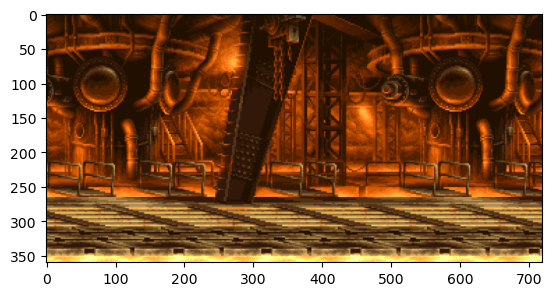

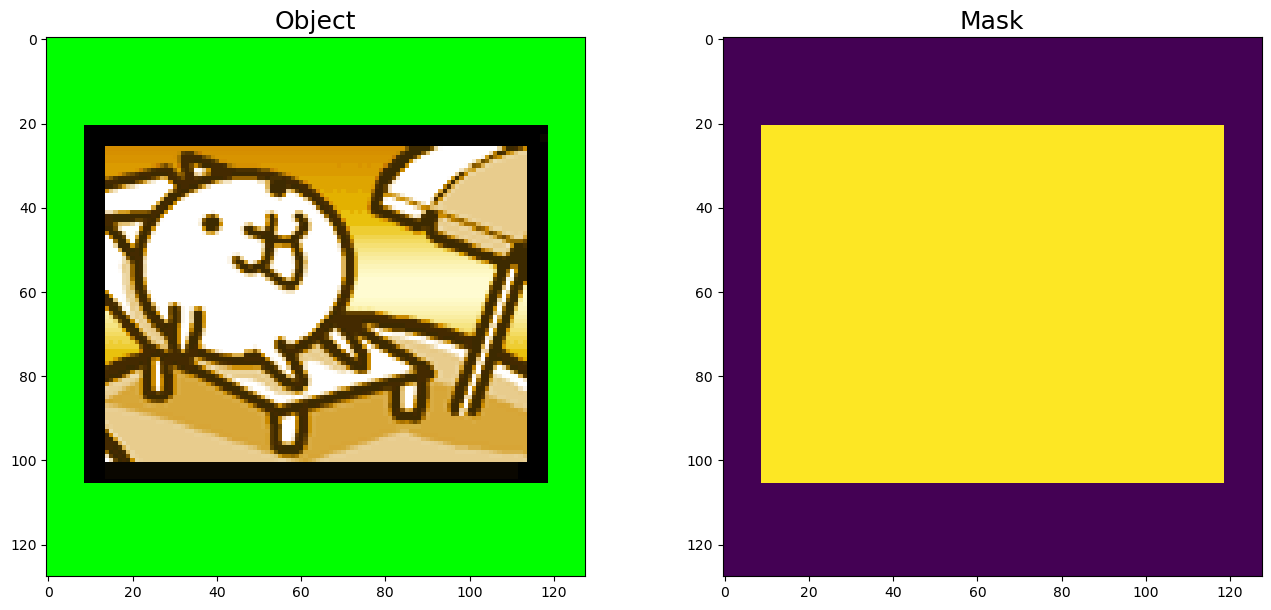

In [6]:
# Let's look at a random object and its binary mask

img_path = cats[20].path
bg_path = backgrounds[20].path
img, mask = get_img_and_mask(img_path)
bg = resize_bg(get_background(bg_path))
print("Image file:", img_path)
print()
print("Shape of the image of the object:", img.shape)
print("Shape of the mask of the object:", mask.shape)
print("Shape of the background:", bg.shape)

plt.imshow(bg)
fig, ax = plt.subplots(1, 2, figsize=(16, 7))
ax[0].imshow(img)
ax[0].set_title('Object', fontsize=18)
ax[1].imshow(mask)
ax[1].set_title('Mask', fontsize=18)
plt.show()


In [7]:
def add_img_to_background(im: np.ndarray, mask: np.ndarray, bg: np.ndarray, x: int, y: int):
    bg = bg.copy()
    bg_h, bg_w = bg.shape[0], bg.shape[1]
    im_h, im_w = im.shape[0], im.shape[1]
    b_sx, b_sy = max(0, x), max(0, y)
    b_ex, b_ey = min(bg_w, x + im_w), min(bg_h, y + im_h)
    i_sx, i_sy = x - b_sx, y - b_sy
    i_ex, i_ey = b_ex - x, b_ey - y

    mask_boolean = mask == 0
    mask_rgb_boolean = np.stack([mask_boolean, mask_boolean, mask_boolean], axis=2)
    bg[b_sy:b_ey, b_sx:b_ex, :] *= mask_rgb_boolean[i_sy:i_ey, i_sx:i_ex, :]
    bg[b_sy:b_ey, b_sx:b_ex, :] += (im * ~mask_rgb_boolean)[i_sy:i_ey, i_sx:i_ex, :]
    return bg


In [8]:
def gen_data():
    cat_id = sample(range(len(cats)), 10)
    cat_id = np.reshape(cat_id, (5, 2))
    bg_path = choice(backgrounds).path
    bg = get_background(bg_path)
    im_w = 128
    sep_x = 3
    x = (bg.shape[1] - im_w * 5 - sep_x * 4) // 2
    y = 200
    dx = im_w + sep_x
    dy = 100
    cat_loc = {}
    for loc, cid in np.ndenumerate(cat_id):
        cat = cats[cid]
        loc = np.array(loc)
        loc = (x, y) + loc * (dx, dy)
        im, imm = get_img_and_mask(cat.path)
        bg = add_img_to_background(im, imm, bg, *loc)
        mid = loc + np.array([dx, dy]) // 2
        name = os.path.splitext(cat.name)[0]
        cat_loc[cid] = mid

    return bg, cat_loc

{1133: array([124, 250]), 294: array([124, 350]), 1219: array([255, 250]), 362: array([255, 350]), 798: array([386, 250]), 1448: array([386, 350]), 207: array([517, 250]), 1578: array([517, 350]), 1406: array([648, 250]), 94: array([648, 350])}
(880, 770, 3)


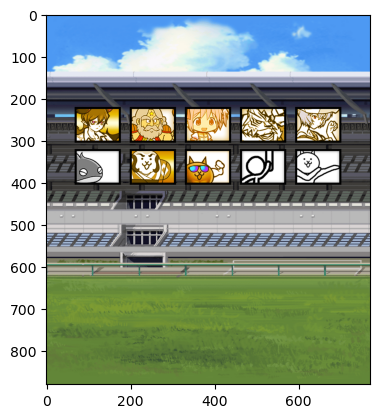

In [9]:
mix, cat_loc = gen_data()
print(cat_loc)
print(mix.shape)
plt.imshow(mix)
plt.show()

In [10]:
def create_yolo_annotations(comp_img, cat_loc: dict[str, np.array]):
    w = 128 - 9 * 2
    h = 128 - 21 * 2
    comp_h, comp_w = comp_img.shape[:2]
    annotations = []
    for cat, loc in cat_loc.items():
        loc = loc.astype(np.float64)
        loc /= (comp_w, comp_h)
        annotations.append([cat,
                            round(loc[0], 5),
                            round(loc[1], 5),
                            round(w / comp_w, 5),
                            round(h / comp_h, 5)])
    return annotations

In [11]:
def generate_dataset(number, folder, split='train'):
    time_start = time.time()
    for j in tqdm(range(number)):
        mix, cat_loc = gen_data()
        mix = cv2.cvtColor(mix, cv2.COLOR_RGB2BGR)
        img_path = os.path.join(folder, split, 'images', f'{j}.jpg')
        label_path = os.path.join(folder, split, 'labels', f'{j}.txt')
        cv2.imwrite(img_path, mix)
        annotations = create_yolo_annotations(mix, cat_loc)

        with open(label_path, "w") as f:
            for annotation in annotations:
                f.write(' '.join(map(str, annotation)) + '\n')

    time_end = time.time()
    time_total = round(time_end - time_start)
    time_per_img = round((time_end - time_start) / number, 1)

    print(
        f"Generation of {number} synthetic images is completed. It took {time_total} seconds, or {time_per_img} seconds per image")
    print(f"Images are stored in '{os.path.join(folder, split, 'images')}'")
    print(f"Annotations are stored in '{os.path.join(folder, split, 'labels')}'")

In [12]:
data_set_folder = 'datasets'
if not os.path.exists(data_set_folder):
    os.mkdir(data_set_folder)
train_folder = os.path.join(data_set_folder, 'train')
valid_folder = os.path.join(data_set_folder, 'valid')
for folder in [train_folder, valid_folder]:
    if not os.path.exists(folder):
        os.makedirs(folder)
    for child in ['images', 'labels']:
        if not os.path.exists(os.path.join(folder, child)):
            os.makedirs(os.path.join(folder, child))

generate_dataset(1000, folder=data_set_folder, split='train')
generate_dataset(200, folder=data_set_folder, split='valid')

100%|██████████| 1000/1000 [00:23<00:00, 42.86it/s]


Generation of 1000 synthetic images is completed. It took 23 seconds, or 0.0 seconds per image
Images are stored in 'dataset\train\images'
Annotations are stored in 'dataset\train\labels'


100%|██████████| 200/200 [00:04<00:00, 42.37it/s]

Generation of 200 synthetic images is completed. It took 5 seconds, or 0.0 seconds per image
Images are stored in 'dataset\valid\images'
Annotations are stored in 'dataset\valid\labels'


Create YAML File

In [15]:
text = f"""
path: ''
train: 'train/images'
val: 'valid/images'

# class names
names: 
"""
names = [f"    {i}:'{f.name.split('.')[0]}'\n" for i,f in enumerate(cats)]

with open(os.path.join('cats_data.yaml'), 'w') as f:
    f.write(text)
    f.writelines(names)